# Acquiring data on cities

This notebook acquires data about cities that GANS operates in from Wikipedia (via web scraping) and OpenWeatherMap (via API access).

## Import libraries 💾

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

## Credentials
For storing your MySQL parameters (including password) and your OpenWeatherMap API key, make a `.env` file in the directory holding this notebook with the following content:
```env
# parameters for MySQL
host="127.0.0.1"
user="user"
password="password"
port=3306
# API key for OpenWeatherMap
openweathermap_key="key"
```

## Web scraping Wikipedia

Utilise your web scraping skills to gather information about three German cities – Berlin, Hamburg, and Munich – from Wikipedia. You will start by extracting the population of each city and then expand the scope of your data gathering to include latitude and longitude, country, and possibly other relevant details.

1. Population Scraping

  1.1. Begin by scraping the population of each city from their respective Wikipedia pages:

 - Berlin: https://en.wikipedia.org/wiki/Berlin
 - Hamburg: https://en.wikipedia.org/wiki/Hamburg
 - Munich: https://en.wikipedia.org/wiki/Munich

  1.2. Once you have scrapped the population of each city, reflect on the similarities and patterns in accessing the population data across the three pages. Also, analyse the URLs to identify any commonalities. Make a loop that executes once but simultaneously retrieves the population for all three cities.

2. Data Organisation

  Utilise pandas DataFrame to effectively store the extracted population data. Ensure the data is clean and properly formatted. Remove any unnecessary characters or symbols and ensure the column data types are accurate.

3. Further Enhancement

  3.1. Expand the scope of your data gathering by extracting other relevant information for each city:

 - Latitude and longitude
 - Country of location

  3.2. Create a function from the loop and DataFrame to encapsulate the scraping process. This function can be used repeatedly to fetch updated data whenever necessary. It should return a clean, properly formatted DataFrame.

4. Global Data Scraping

  With your robust scraping skills now honed, venture beyond the confines of Germany and explore other cities around the world. While the extraction methodology for German cities may follow a consistent pattern, this may not be the case for cities from different countries. Can you make a function that returns a clean DataFrame of information for cities worldwide?

In [2]:
# Store soups that we previously retrieved, so we donot cause unnecessary traffic and delays:
try:
  cached_soup
except NameError:
  cached_soup = {}

In [3]:
#! pip install lat_lon_parser

In [4]:
from datetime import datetime
import urllib
import json
import lat_lon_parser
import re

url_pattern = 'https://en.wikipedia.org/wiki/{city}'
wikidata_pattern = 'https://www.wikidata.org/wiki/Special:EntityData/{entity}.json'

def parseNumber(number):
  if match := re.search(r'(\d+)', number.replace(',', '')):
    return int(match.group(1))
  return None

def parseDate(date):
  # 31 December 2018, see Zürich
  if match := re.search(r'\((\d+ \w+ \d{4})(\s.*)?\)', date):
    return datetime.strptime(match.group(1), '%d %B %Y').strftime('%Y-%m-%d')
  # 2018-12-31, see Hamburg
  if match := re.search(r'\((\d{4}-\d\d-\d\d)(\s.*)?\)', date):
    return match.group(1)
  # 2022, see most others
  if match := re.search(r'\((20\d\d)(\s.*)?\)', date):
    return match.group(1)
  return None

def getSoup(url):
  if soup := cached_soup.get(url):
    return soup
  response = requests.get(url)
  soup = BeautifulSoup(response.content, 'html.parser')
  cached_soup[url] = soup
  return soup

def scrapeCity(city):
  city_soup = getSoup(url_pattern.format(city=urllib.parse.quote(city)))

  for ib in city_soup.select('.infobox'): # .ib-settlement would be nicer but Sydney uses infobox only
    latitude = ib.select_one('.latitude').text
    longitude = ib.select_one('.longitude').text
    country = None
    date = None
    population = None

    for th in ib.select('.infobox-label'):
      if th.text == 'Country':
        country = th.parent.select_one('.infobox-data').text
      elif th.text.startswith('Population'):
        date = parseDate(th.text)
        infobox_data = th.parent.select_one('.infobox-data')
        population = parseNumber(infobox_data.text)
        if not date:
          date = parseDate(infobox_data.text)

    for th in ib.select('.infobox-header'):
      if population == None and th.text.startswith('Population'):
        date = parseDate(th.text)

        if data := th.parent.select_one('.infobox-data'):
          population = parseNumber(data.text)
          continue

        next_tr = th.parent.next_sibling
        if not re.match(r'\s*•\s+(City|Capital city|Total|Municipality)', next_tr.select_one('.infobox-label').text):
          continue

        population = parseNumber(next_tr.select_one('.infobox-data').text)
    break

  # WikiData
  # wikidata_entity = city_soup.select_one('#t-wikibase a')['href'].rsplit('/', 1)[-1]
  # wikidata_url = wikidata_pattern.format(entity=wikidata_entity)
  # print(wikidata_url)
  # wikidata_json = json.loads(requests.get(wikidata_pattern.format(entity=wikidata_entity)).content)
  # print(wikidata_json['entities'][wikidata_entity]['claims']['P2044'][0]['mainsnak']['datavalue']['value']['amount'])
  
  wikidata_soup = getSoup(city_soup.select_one('#t-wikibase a')['href'])
  try:
    base_elevation = wikidata_soup.select_one('#P2044 .wikibase-snakview-value').text
  except:
    base_elevation = None

  try:
    peak_elevation = wikidata_soup.select_one('#P610 .wikibase-statementview-qualifiers .wikibase-snakview-value').text
  except:
    peak_elevation = None
  
  return pd.DataFrame({
        'city': [city],
        'country': [country],
        'latitude': [lat_lon_parser.parse(latitude)],
        'longitude': [lat_lon_parser.parse(longitude)],
        'base_elevation': [base_elevation],
        'peak_elevation': [peak_elevation],
        'population': [population],
        'date': [date]})

def scrapeCities(cities = [ 'Berlin', 'Hamburg', 'Munich' ]):
  df = None
  for city in cities:
    print(city)
    df = pd.concat([df, scrapeCity(city)], ignore_index=True)
  return df

scrapeCity('Berlin')

,city,country,latitude,longitude,base_elevation,peak_elevation,population,date
0,Berlin,Germany,52.52,13.405,34±1 metre,121.9 metre,3850809,2021


In [5]:
df = scrapeCities([
    'Berlin',
    'Hamburg',
    'Munich',
    'Stuttgart',
    'Tübingen',
    'Potsdam',
    'Werder (Havel)',
    'Paris',
    'London',
    'Vienna',
    'Warsaw',
    'Prague',
    'Zürich',
    'New York City',
    'Tokyo',
    'Beijing',
    'Moscow',
    'Sydney'
    ])

df

Berlin
Hamburg
Munich
Stuttgart
Tübingen
Potsdam
Werder (Havel)
Paris
London
Vienna
Warsaw
Prague
Zürich
New York City
Tokyo
Beijing
Moscow
Sydney


,city,country,latitude,longitude,base_elevation,peak_elevation,population,date
0,Berlin,Germany,52.520000,13.405000,34±1 metre,121.9 metre,3850809,2021
1,Hamburg,Germany,53.550000,10.000000,6±1 metre,116.2 metre,1945532,2022-12-31
2,Munich,Germany,48.137500,11.575000,519±1 metre,None,1512491,2022-12-31
3,Stuttgart,Germany,48.777500,9.180000,245±1 metre,None,626275,2021-12-31
4,Tübingen,Germany,48.520000,9.055556,338 metre,None,91877,2021-12-31
5,Potsdam,Germany,52.400000,13.066667,35 metre,None,183154,2021-12-31
6,Werder (Havel),Germany,52.383333,12.933333,31±1 metre,None,26767,2021-12-31
7,Paris,France,48.856667,2.352222,28±1 metre,None,2102650,2023
8,London,England,51.507222,-0.127500,15 metre,245 metre,8799800,2021
9,Vienna,Austria,48.208333,16.372500,151 metre,None,2002821,None


In [6]:
import dotenv
import os
dotenv.load_dotenv()

schema = "wbscs_cities"
host = os.getenv('host')
user = os.getenv('user')
password = os.getenv('password')
port = os.getenv('port')

connection_string = f'mysql+pymysql://{user}:{password}@{host}:{port}/{schema}'

from sqlalchemy import create_engine, text, inspect
connection = create_engine(connection_string).connect()

In [7]:
def resetDatabase():
    connection.execute(text('DROP TABLE IF EXISTS weather;'))
    connection.execute(text('DROP TABLE IF EXISTS fact;'))
    connection.execute(text('DROP TABLE IF EXISTS city;'))
    connection.execute(text('DROP TABLE IF EXISTS measure;'))
    connection.execute(text('DROP TABLE IF EXISTS scrape;'))

def initDatabase():
    if len(inspect(connection).get_table_names()):
        return

    connection.execute(text(
        '''
        CREATE TABLE city (
            id INT AUTO_INCREMENT KEY,
            name TEXT NOT NULL,
            country TEXT,
            latitude DOUBLE,
            longitude DOUBLE,
            base_elevation TEXT,
            peak_elevation TEXT
        );
        '''));

    connection.execute(text(
        '''
        CREATE TABLE scrape (
            id INT AUTO_INCREMENT KEY,
            timestamp TIMESTAMP NOT NULL DEFAULT CURRENT_TIMESTAMP
        );
        '''));

    connection.execute(text(
        '''
        CREATE TABLE measure (
            id INT AUTO_INCREMENT KEY,
            name TEXT NOT NULL,
            type TEXT NOT NULL
        );
        '''));

    connection.execute(text(
        '''
        CREATE TABLE fact (
            scrape INT NOT NULL REFERENCES scrape(id) ON DELETE CASCADE ON UPDATE CASCADE,
            city INT NOT NULL REFERENCES city(id) ON DELETE CASCADE ON UPDATE CASCADE,
            measure INT NOT NULL REFERENCES measure(id) ON DELETE CASCADE ON UPDATE CASCADE,
            value TEXT NOT NULL,
            meta JSON NULL DEFAULT NULL
        );
        '''));

    connection.execute(text(
        '''
        CREATE TABLE weather (
            scrape INT NOT NULL REFERENCES scrape(id) ON DELETE CASCADE ON UPDATE CASCADE,
            city INT NOT NULL REFERENCES city(id) ON DELETE CASCADE ON UPDATE CASCADE,
            dt DATETIME NOT NULL,
            T_feelslike_celsius FLOAT NOT NULL,
            rain_3h_mm FLOAT NOT NULL,
            snow_3h_mm FLOAT NOT NULL
        );
        '''));

def newScrapeId():
  return connection.execute(text('insert into scrape values() returning id')).first().id

def newMeasureId(measure, type_):
  return connection.execute(text(f'insert into measure(name, type) values("{measure}", "{type_}") returning id')).first().id

resetDatabase()
initDatabase()

In [8]:
cities_df = df[['city','country','latitude','longitude','base_elevation','peak_elevation']].rename(columns={'city': 'name'})

In [9]:
cities_df.to_sql('city',
                  if_exists='append',
                  con=connection,
                  index=False)

18

In [10]:
cities_df = pd.read_sql('city', con=connection).set_index('id')

In [11]:
scrape_id = newScrapeId()
population_id = newMeasureId('population', 'number')

In [12]:
(
    df[['city','population','date']]
    .join(
        cities_df
        [['name']]
        .reset_index()
        .set_index('name'),
        on='city')
    .drop(columns=['city'])
    .rename(columns={'id': 'city', 'population': 'value'})
    .assign(
        scrape=scrape_id, 
        measure=population_id,
        meta=lambda x: x.apply(lambda r: f'{{"date": "{r.date}"}}' if r.date else None, axis=1) )
    .drop(columns=['date'])
).to_sql('fact', con=connection, if_exists='append', index=False)

18

In [13]:
facts_df = pd.read_sql('fact', con=connection)
facts_df

,scrape,city,measure,value,meta
0,1,1,1,3850809,"{""date"": ""2021""}"
1,1,2,1,1945532,"{""date"": ""2022-12-31""}"
2,1,3,1,1512491,"{""date"": ""2022-12-31""}"
3,1,4,1,626275,"{""date"": ""2021-12-31""}"
4,1,5,1,91877,"{""date"": ""2021-12-31""}"
5,1,6,1,183154,"{""date"": ""2021-12-31""}"
6,1,7,1,26767,"{""date"": ""2021-12-31""}"
7,1,8,1,2102650,"{""date"": ""2023""}"
8,1,9,1,8799800,"{""date"": ""2021""}"
9,1,10,1,2002821,None


In [14]:
measures_df = pd.read_sql('measure', con=connection).set_index('id')
measures_df

,name,type
id,,
1,population,number


## OpenWeatherMap data via API

In [15]:
cities_df

,name,country,latitude,longitude,base_elevation,peak_elevation
id,,,,,,
1,Berlin,Germany,52.520000,13.405000,34±1 metre,121.9 metre
2,Hamburg,Germany,53.550000,10.000000,6±1 metre,116.2 metre
3,Munich,Germany,48.137500,11.575000,519±1 metre,None
4,Stuttgart,Germany,48.777500,9.180000,245±1 metre,None
5,Tübingen,Germany,48.520000,9.055556,338 metre,None
6,Potsdam,Germany,52.400000,13.066667,35 metre,None
7,Werder (Havel),Germany,52.383333,12.933333,31±1 metre,None
8,Paris,France,48.856667,2.352222,28±1 metre,None
9,London,England,51.507222,-0.127500,15 metre,245 metre


In [16]:
openweathermap_pattern = 'https://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lon}&appid={openweathermap_key}&units=metric'
openweathermap_key = os.getenv('openweathermap_key')

In [17]:
try:
  cached_json
except:
  cached_json = {}

In [18]:
def getJson(url):
  if json := cached_json.get(url):
    return json
  response = requests.get(url)
  json = response.json()
  cached_json[url] = json
  return json

In [19]:
def getWeather(city=None, lat=None, lon=None):
  if city != None:
    latlon = cities_df.set_index('name').loc[city, ['latitude', 'longitude']]
    return getWeather(lat=latlon['latitude'], lon=latlon['longitude'])
  
  url = openweathermap_pattern.format(lat=lat, lon=lon, openweathermap_key=openweathermap_key)
  json = getJson(url)
  df = pd.json_normalize(json['list'])
  for optional in ['rain.3h', 'snow.3h']:
    if not optional in df:
      df[optional] = None
  df.dt = pd.to_datetime(df.dt, unit='s')
  return df[['dt', 'main.feels_like', 'rain.3h', 'snow.3h']].fillna(0)
  #print(json.dumps(response.json(), indent=2, sort_keys=True))
  
getWeather(city='Berlin')

,dt,main.feels_like,rain.3h,snow.3h
0,2024-01-10 21:00:00,-7.23,0.00,0.00
1,2024-01-11 00:00:00,-7.19,0.00,0.00
2,2024-01-11 03:00:00,-8.09,0.00,0.00
3,2024-01-11 06:00:00,-7.57,0.00,0.00
4,2024-01-11 09:00:00,-6.52,0.00,0.00
5,2024-01-11 12:00:00,-4.06,0.00,0.00
6,2024-01-11 15:00:00,-4.55,0.00,0.00
7,2024-01-11 18:00:00,-4.42,0.00,0.00
8,2024-01-11 21:00:00,-4.66,0.00,0.00
9,2024-01-12 00:00:00,-3.24,0.00,0.00


In [21]:
def scrapeWeather():
  scrape_id = newScrapeId()
  for city_id, city in cities_df['name'].items():
    rows = (
      getWeather(city=city)
      .assign(city=city_id, scrape=scrape_id)
      .rename(columns={'main.feels_like':'T_feelslike_celsius', 'rain.3h': 'rain_3h_mm', 'snow.3h': 'snow_3h_mm'})
    ).to_sql('weather', con=connection, index=False, if_exists='append')
    print(city, rows)
        
scrapeWeather()

Berlin 40
Hamburg 40
Munich 40
Stuttgart 40
Tübingen 40
Potsdam 40
Werder (Havel) 40
Paris 40
London 40
Vienna 40
Warsaw 40
Prague 40
Zürich 40
New York City 40
Tokyo 40
Beijing 40
Moscow 40
Sydney 40


In [22]:
weather_df = pd.read_sql('weather', con=connection)
weather_df

,scrape,city,dt,T_feelslike_celsius,rain_3h_mm,snow_3h_mm
0,2,1,2024-01-10 21:00:00,-7.23,0.00,0.0
1,2,1,2024-01-11 00:00:00,-7.19,0.00,0.0
2,2,1,2024-01-11 03:00:00,-8.09,0.00,0.0
3,2,1,2024-01-11 06:00:00,-7.57,0.00,0.0
4,2,1,2024-01-11 09:00:00,-6.52,0.00,0.0
...,...,...,...,...,...,...
715,2,18,2024-01-15 06:00:00,18.59,6.88,0.0
716,2,18,2024-01-15 09:00:00,17.75,1.69,0.0
717,2,18,2024-01-15 12:00:00,17.61,5.79,0.0
718,2,18,2024-01-15 15:00:00,17.64,6.68,0.0


# Summary of acquired data
## Static data

In [23]:
cities_df

,name,country,latitude,longitude,base_elevation,peak_elevation
id,,,,,,
1,Berlin,Germany,52.520000,13.405000,34±1 metre,121.9 metre
2,Hamburg,Germany,53.550000,10.000000,6±1 metre,116.2 metre
3,Munich,Germany,48.137500,11.575000,519±1 metre,None
4,Stuttgart,Germany,48.777500,9.180000,245±1 metre,None
5,Tübingen,Germany,48.520000,9.055556,338 metre,None
6,Potsdam,Germany,52.400000,13.066667,35 metre,None
7,Werder (Havel),Germany,52.383333,12.933333,31±1 metre,None
8,Paris,France,48.856667,2.352222,28±1 metre,None
9,London,England,51.507222,-0.127500,15 metre,245 metre


## Dynamic data

In [24]:
scrapes_df = pd.read_sql('scrape', con=connection).set_index('id')
scrapes_df

,timestamp
id,
1,2024-01-10 21:31:21
2,2024-01-10 21:31:21


In [25]:
(
  facts_df
  .join(measures_df.rename(columns={'name': 'measure_name', 'type': 'measure_type'}), on='measure')
  .join(cities_df.name.rename('city_name'), on='city')
  .join(scrapes_df.timestamp.rename('scrape_timestamp'), on='scrape')
  [['city_name','measure_name','value','meta','scrape_timestamp']]
)

,city_name,measure_name,value,meta,scrape_timestamp
0,Berlin,population,3850809,"{""date"": ""2021""}",2024-01-10 21:31:21
1,Hamburg,population,1945532,"{""date"": ""2022-12-31""}",2024-01-10 21:31:21
2,Munich,population,1512491,"{""date"": ""2022-12-31""}",2024-01-10 21:31:21
3,Stuttgart,population,626275,"{""date"": ""2021-12-31""}",2024-01-10 21:31:21
4,Tübingen,population,91877,"{""date"": ""2021-12-31""}",2024-01-10 21:31:21
5,Potsdam,population,183154,"{""date"": ""2021-12-31""}",2024-01-10 21:31:21
6,Werder (Havel),population,26767,"{""date"": ""2021-12-31""}",2024-01-10 21:31:21
7,Paris,population,2102650,"{""date"": ""2023""}",2024-01-10 21:31:21
8,London,population,8799800,"{""date"": ""2021""}",2024-01-10 21:31:21
9,Vienna,population,2002821,None,2024-01-10 21:31:21


## Prospective data

In [26]:
joined_weather_df = (
  weather_df
  .join(cities_df.name.rename('city_name'), on='city')
  .join(scrapes_df.timestamp.rename('scrape_timestamp'), on='scrape')
  [['city_name', 'dt', 'T_feelslike_celsius', 'rain_3h_mm', 'snow_3h_mm', 'scrape_timestamp']]
)
joined_weather_df

,city_name,dt,T_feelslike_celsius,rain_3h_mm,snow_3h_mm,scrape_timestamp
0,Berlin,2024-01-10 21:00:00,-7.23,0.00,0.0,2024-01-10 21:31:21
1,Berlin,2024-01-11 00:00:00,-7.19,0.00,0.0,2024-01-10 21:31:21
2,Berlin,2024-01-11 03:00:00,-8.09,0.00,0.0,2024-01-10 21:31:21
3,Berlin,2024-01-11 06:00:00,-7.57,0.00,0.0,2024-01-10 21:31:21
4,Berlin,2024-01-11 09:00:00,-6.52,0.00,0.0,2024-01-10 21:31:21
...,...,...,...,...,...,...
715,Sydney,2024-01-15 06:00:00,18.59,6.88,0.0,2024-01-10 21:31:21
716,Sydney,2024-01-15 09:00:00,17.75,1.69,0.0,2024-01-10 21:31:21
717,Sydney,2024-01-15 12:00:00,17.61,5.79,0.0,2024-01-10 21:31:21
718,Sydney,2024-01-15 15:00:00,17.64,6.68,0.0,2024-01-10 21:31:21


/home/til/local/opt/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


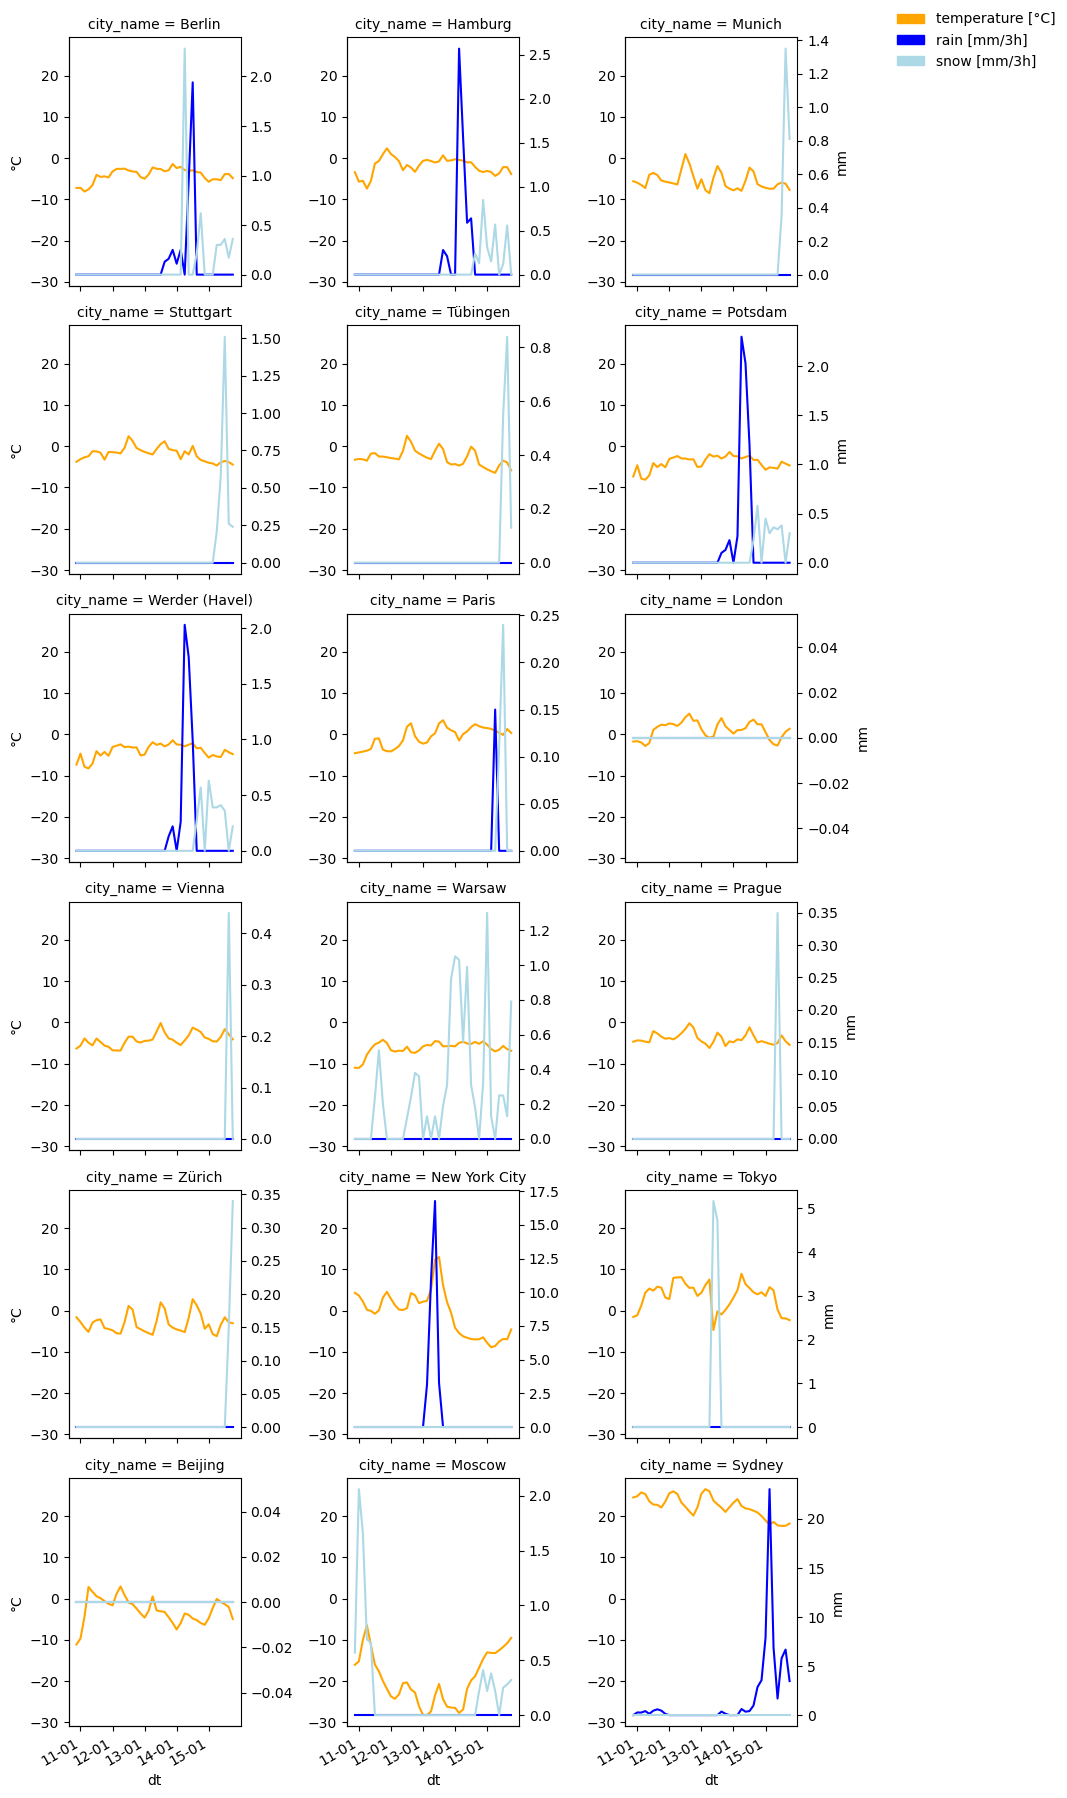

In [33]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

col_wrap = 3

g = sns.FacetGrid(
    data=joined_weather_df.drop(columns=["scrape_timestamp"]),
    col="city_name",
    col_wrap=col_wrap,
    sharex=True,
)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d-%m"))
name_to_color = {
    "temperature [°C]": "orange",
    "rain [mm/3h]": "blue",
    "snow [mm/3h]": "lightblue",
}

patches = {k: mpatches.Patch(color=v) for k, v in name_to_color.items()}
g = g.map(plt.plot, "dt", "T_feelslike_celsius", color="orange").add_legend(patches)
g.set(ylabel="°C")
plt.gcf().autofmt_xdate()

for ax, ((i, j, k), subdata) in zip(g.axes, g.facet_data()):
    ax2 = ax.twinx()
    if j % col_wrap == col_wrap - 1:
        ax2.set(ylabel="mm")
    ax2.plot(subdata["dt"], subdata["rain_3h_mm"], color="blue")
    ax2.plot(subdata["dt"], subdata["snow_3h_mm"], color="lightblue")

g.tight_layout()
sns.move_legend(g, "upper right")